In [1]:
# import json

# jsonfile = {}

# jsonObject = json.dumps(jsonfile, indent=4)

# with open('ALL_SHIP_VIA.json', 'w') as outfile:  
#     outfile.write(jsonObject)

In [2]:
# with open('testfile.json', 'r') as file:
#     data = json.load(file)
#     data["add"] = {}


In [3]:
# with open('ALL_SHIP_VIA.json', 'w') as file:
#     json.dump(data, file, indent=4)

In [4]:
# #To Append Each Time to {}
# "ordrNo" : {
#     "dateReceived" : None,
#     "pages" : None,
#     "originalPrint" : None,
#     "reprintDate" : None,
#     "emailAttachment" : None,
# }

In [5]:
import json 

def load_json(file_name):
    '''
    file_name = .json file
    '''
    with open(file_name, 'r') as read_file:
        loaded_data = json.load(read_file) # load master data
    return loaded_data

def add_to_json(file_name, key, value):
    '''
    file_name = .json file
    key = "order_no" of the target file
    value = {
                    "dateReceived" : None,
                    "originalPrint" : None,
                    "reprintDate" : None,
                    "emailAttachment" : None,
                    "fileDirectory" : None,
                    "status" : None,
                    "isExcelUpdated" : None
            }
    
    1) open json file, load data, append new data
    2) open json file, dump/save the same data to json
    
    difference 'r' and 'w'
    
    data structure to add to dictionary: 
    "ordrNo" : {
                    "dateReceived" : None,
                    "originalPrint" : None,
                    "reprintDate" : None,
                    "emailAttachment" : None,
                    "fileDirectory" : None,
                    "status" : None,
                    "isExcelUpdated" : None
                }
    "ordrNo_reprint": {
                    "dateReceived" : None,
                    "originalPrint" : None,
                    "reprintDate" : None,
                    "emailAttachment" : None,
                    "fileDirectory" : None,
                    "status" : None,
                    "isExcelUpdated" : None
                }
    '''
    with open(file_name, 'r') as read_file:
        loaded_data = json.load(read_file) # load master data
        loaded_data[key] = value # append to master data
    
    with open(file_name, 'w') as write_file:
        json.dump(loaded_data, write_file, indent=4)
        
def update_values(file_name, key, update_key, value):
    '''
    file_name = .json file
    key = to find "order_no" in hashable dict
    update_key = from one of ["dateReceived",
                    "originalPrint",
                    "reprintDate",
                    "emailAttachment",
                    "fileDirectory",
                    "status",
                    "isExcelUpdated"], also used to add new (k, v) pairs within key 
    value = update value in (update_key, value) pair
    '''
    with open(file_name, 'r') as read_file:
        loaded_data = json.load(read_file) # load master data
        loaded_data[key][update_key] = value # append to master data
    
    with open(file_name, 'w') as write_file:
        json.dump(loaded_data, write_file, indent=4)

In [6]:
from datetime import date
import os

def paths(root_path):
    '''
    root_path = takes in path where email_attachments are saved (must be r'str')
    
    all_paths = {} is a dictionary to all required directories 
    '''
    today = date.today()

    pick_ticket_path = root_path + '\\master_pick_tickets'
    email_archive = root_path + '\\email_archive'

    all_paths = {
        'root_path' : root_path,
        'pick_ticket_path' : pick_ticket_path,
        'email_archive' : email_archive,
    }
    return all_paths



def create_directory(path):
    '''
    path = directory to create (must be r'str')
    '''
    try:
        os.mkdir(path)
    except OSError:
        print ("Creation of the directory %s failed" % path)
        


def enter_directory(path):
    '''
    path = directory to enter(must be r'str')
    '''
    try: 
        os.chdir(path)
    except OSError:       
        print("Entering the directory %s failed" % path)
        
        
        
def verify_directory(path):
    '''
    path = directory to verify (must be r'str')
    '''
    return os.path.exists(path)



def move_files(src, dst):
    '''
    src = path to file (.pdf)
    dst = new path to file (.pdf)
    '''
    try:
        os.replace(src, dst)
    except:
        os.rename(src, dst)

In [7]:
import glob
import os

def list_of_files(path, file_ending='*.pdf'):
    '''
    path = directory of files
    file_ending = type of files (default = ".pdf")
    '''
    return glob.glob(os.path.join(path, file_ending))

In [8]:
from PyPDF2 import PdfFileWriter, PdfFileReader

def read_file(file, json_data, jsonfile, extraction_info, move_to):
    '''
    file = emailed file (mail%^**&^%.pdy)
    json_data = loaded json data (load everytime before calling this function)
    jsonfile = main json file ("master_pick_tickets.json")
    
    orders_dict = tracks the indices of page(s) this function has to extract from file
    json_dict_to_add = for each file json data for all picktickets is loaded only once and then appended to jsonfile
    
    data extracted form each page:
    {
        originalPrint, 
        reprintDate, 
        dateReceived, 
        emailAttachment, 
        shipTo, 
        via, 
        fileDirectory, 
        status = "Just Received", 
        shippedDate = None,
        billedDate = None,
        isExcelUpdated = False
        isShippedExcelUpdated = False,
        isBilledExcelUpdated = False,
    }
    
    if order_no already exists in previous email attachment, then "_reprint" is appended to order_no ("7182345-00_reprint")
    '''
    orders_dict = {}
    json_dict_to_add = {}
    with open(file, 'rb') as readfile:
        input_file = PdfFileReader(readfile)
        pages = input_file.numPages

        
        for page in range(pages):
            file_writer = PdfFileWriter()
            get_page = input_file.getPage(page)
            
            reprintDate = None
            master_text = get_page.extractText()
            narrowed_text = find_pattern(r'Order(.*)FOB', master_text)
            
            order_no = find_pattern(r'(\d{4,7})[-](\d{2})', narrowed_text)
            originalPrint = True
            if if_order_as_originalPrint(order_no, json_data):
                order_no = if_order_exists_return_renamed(order_no, json_data)
                reprint_dates(order_no, jsonfile, json_dict_to_add, json_data)
                originalPrint = False
            
            dateReceived = str(datetime.now())
            emailAttachment = move_to
            
            shipTo = find_pattern(r"ShipTo(.*)Order", master_text)[8:].split(" ")[:3]
            shipTo = " ".join(shipTo)
            
            via = ship_via("ALL_SHIP_VIA.json", narrowed_text)
            
            fileDirectory = os.getcwd() + rf"\{order_no}.pdf"
            
            try:
                orders_dict[order_no].append(page)
            except:
                orders_dict[order_no] = []
                orders_dict[order_no].append(page)
            
            for each_page in orders_dict[order_no]:
                file_writer.addPage(input_file.getPage(each_page))
                
            with open(f"{order_no}.pdf", "wb") as f:
                file_writer.write(f)
                f.close()
                
            ######## Adding data
            try:
                json_dict_to_add[order_no] = append_data(originalPrint, 
                                                         reprintDate, 
                                                         dateReceived, 
                                                         emailAttachment, 
                                                         shipTo, 
                                                         via,
                                                        fileDirectory)
            except:
                print("could not add data")
                
        for k, v in json_dict_to_add.items():
            add_to_json(jsonfile, k, v)
            
        prettyInfo(file, pages, extraction_info)

In [9]:
# if order no ['original_print'] == True:
# add "_reprint"
from datetime import datetime


def reprint_dates(order_no, jsonfile, json_dict_to_verify, json_data):
    '''
    order_no = OrderNo from pickticket
    jsonfile = main json file ("master_pick_tickets.json")
    json_dict_to_verify = "json_dict_to_add" in read_file()
    json_data = loaded json data (load everytime before calling "read_file" function)
    '''
    target = json_data[order_no[:10]]['reprintDate']
    if not order_no in json_dict_to_verify:
        try:
            target.append(str(datetime.now()))
        except:
            target = []
            target.append(str(datetime.now()))
        update_values(jsonfile, order_no[:10], "reprintDate", target)
        
    

def if_order_as_originalPrint(order_no, json_data):
    '''
    order_no = OrderNo from pickticket
    json_data = loaded json data (load everytime before calling "read_file()" function)
    '''
    if order_no in json_data:
        return json_data[order_no]["originalPrint"]

def if_order_exists_return_renamed(order_no, json_data):
    '''
    order_no = OrderNo from pickticket
    json_data = loaded json data (load everytime before calling "read_file()" function)
    '''
    while order_no in json_data:
        order_no = order_no + "_reprint"
    return order_no 

def append_data(originalPrint, reprintDate, dateReceived, 
                emailAttachment, shipTo, via, fileDirectory, 
                status="Just Received", shippedDate=None, billedDate=None, 
                isExcelUpdated=False, isShippedExcelUpdated=False, isBilledExcelUpdated=False):
    '''
    all mandatory data
    '''
    return_dict = {
                    "dateReceived" : dateReceived,
                    "originalPrint" : originalPrint,
                    "reprintDate" : reprintDate,
                    "emailAttachment" : emailAttachment,
                    "shipTo" : shipTo,
                    "via": via,
                    "fileDirectory" : fileDirectory,
                    "status" : status,
                    "shippedDate" : shippedDate,
                    "billedDate" : billedDate,
                    "isExcelUpdated" : isExcelUpdated,
                    "isShippedExcelUpdated" : isShippedExcelUpdated,
                    "isBilledExcelUpdated" : isBilledExcelUpdated,
                    }
    return return_dict

def ship_via(jsonfile, narrowed_text):
    '''
    jsonfile = main json file ("ALL_SHIP_VIA.json")
    narrowed_text = is narrowed_text in read_file() function
    
    matches "via" with SX data for "ship via"
    '''
    via_json = load_json(jsonfile)
    via_return = "NOT FOUND"
    for via_name in via_json["Signode_Ship_Via"]:
        if via_name in narrowed_text:
            via_return = via_name
    return via_return

In [10]:
try:
    import re2 as re
except ImportError:
    import re

def find_pattern(pattern_to_search_for, data):
    '''
    pattern_to_search_for = pattern match (must be r'str') 
    data = find pattern in data
    '''
    pattern = re.compile(pattern_to_search_for)
    pattern_matches = pattern.finditer(data)
    initial_match = [match for match in pattern_matches]
    return initial_match[0].group(0)

In [11]:
from prettytable import PrettyTable

def table():
    extraction_info = PrettyTable()
    extraction_info.field_names = ["pdf file name", "num of pages extracted"]
    return extraction_info

def prettyInfo(file, pages, extraction_info):
    '''
    file = emailed file (mail%^**&^%.pdy)
    pages = pages in file
    '''
    extraction_info.add_row([os.path.basename(file), pages])
    
def print_to_console(extraction_info):
    '''
    info = extraction_info
    '''
    print(extraction_info)

In [12]:
# import pandas as pd
# import os
# os.chdir(r"C:\Users\0235124\OneDrive - University of Waterloo\Desktop\signodeProjects\pdfParse\pyPDF2\python_code\STABLE CODE\test\master_pick_tickets")

# df = pd.read_json("master_pick_tickets.json")
# df = df.transpose()
# df.to_excel("op1.xlsx")


In [13]:
# from openpyxl import Workbook

# os.chdir(r"C:\Users\0235124\OneDrive - University of Waterloo\Desktop\signodeProjects\pdfParse\pyPDF2\python_code\STABLE CODE\Jupyter")

# workbook = Workbook()
# sheet = workbook.active

# sheet["A1"] = "hello"
# sheet["B1"] = "world!"

# workbook.save(filename="hello_world.xlsx")


In [14]:
# from .json import load_json, add_to_json, update_values 
# from .path import paths, create_directory, enter_directory, verify_directory, move_files
# from .algorithm import read_file
# from .algoHelpers import reprint_dates, if_order_as_originalPrint, if_order_exists_return_renamed, append_data, ship_via
# from .pattern import find_pattern
# from .prettytable import prettyInfo, print_to_console
# from allFiles import list_of_files

In [15]:
temp_path = paths(r"C:\Users\0235124\OneDrive - University of Waterloo\Desktop\signodeProjects\pdfParse\pyPDF2\python_code\STABLE CODE\test")
code_path = r"C:\Users\0235124\OneDrive - University of Waterloo\Desktop\signodeProjects\pdfParse\pyPDF2\python_code\STABLE CODE\main"

if os.getcwd() != temp_path["root_path"]:
    enter_directory(temp_path["root_path"])

if not (verify_directory(temp_path["pick_ticket_path"]) and verify_directory(temp_path["email_archive"])):
    create_directory(temp_path["pick_ticket_path"])
    create_directory(temp_path["email_archive"])
    
extraction_info = table()

jsonfile = r"C:\Users\0235124\OneDrive - University of Waterloo\Desktop\signodeProjects\pdfParse\pyPDF2\python_code\STABLE CODE\test\master_pick_tickets\master_pick_tickets.json"

all_files = list_of_files(temp_path["root_path"])

for file in all_files:
    json_data = load_json(jsonfile)
    move_to = temp_path["email_archive"] + rf"\{os.path.basename(file)}"
    
    if os.getcwd() != temp_path["pick_ticket_path"]:
        enter_directory(temp_path["pick_ticket_path"])
        
    read_file(file, json_data, jsonfile, extraction_info, move_to)
    
    if os.getcwd() != temp_path["root_path"]:
        enter_directory(temp_path["root_path"])
    
    move_files(file, move_to)
    
print_to_console(extraction_info)


if os.getcwd() != code_path:
    enter_directory(code_path)

+---------------+------------------------+
| pdf file name | num of pages extracted |
+---------------+------------------------+
+---------------+------------------------+


In [16]:
# temp_path = paths(r"C:\Users\0235124\OneDrive - University of Waterloo\Desktop\signodeProjects\pdfParse\pyPDF2\python_code\STABLE CODE\test")
# print(temp_path)

In [17]:
# import win32com.client as win

# def get_exl_app():
#     active_exl = win.GetActiveObject('Excel.Application')
#     return active_exl

# def dict_of_wrbk(c=0):
#     return_dict = {}
#     active_wrbk = get_exl_app().Workbooks
#     while True:
#         try:
#             return_dict[active_wrbk[c].Name] = c
#             c += 1
#         except IndexError:
#             break
#     return return_dict

# def get_active_exl(active_exl):
#     if active_exl in dict_of_wrbk():
#         return dict_of_wrbk()[active_exl]

# def get_active_sht(active_sht):
#     active_sht = get_exl_app().Workbooks()
#     return active_wrksht


# def lst_unupdated_exl(json_data):
#     list_return = []
#     for k, v in json_data.items():
#         if v["isExcelUpdated"] == False:
#             list_return.append(k)
#     return list_return

# def return_emty_cell(c=2):
#     while active_wrksht.Range(f"{temp_dict['orderNo']}{c}").Value != 0:
#         update_values(file_name, 
#                       active_wrksht.Range(f"{temp_dict['orderNo']}{c}").Value, 
#                       "status", 
#                       active_wrksht.Range(f"{temp_dict['status']}{c}").Value)
#         c += 1
#     return c

# def fill_cell(temp_lst, temp_dict, c):
#     for i in temp_lst[1:]:
#         try:
#             active_wrksht.Range(f"{temp_dict[i]}{c}").Value = temp_json[order][i]
#         except:
#             if i == "friendly_name":
#                 active_wrksht.Range(f"{temp_dict[i]}{c}").Value = order
#             elif i == "rePrint":
#                 active_wrksht.Range(f"{temp_dict[i]}{c}").Value = temp_json[order]["reprintDate"]

In [18]:
# def lst_unupdated_exl(json_data):
#     list_return = []
#     for k, v in json_data.items():
#         if v["isExcelUpdated"] == False:
#             list_return.append(k)
#     return list_return

In [19]:
# c = 2
# while active_wrksht.Range(f"{temp_dict['orderNo']}{c}").Value != 0:
#     update_values(file_name, 
#                   active_wrksht.Range(f"{temp_dict['orderNo']}{c}").Value, 
#                   "status", 
#                   active_wrksht.Range(f"{temp_dict['status']}{c}").Value)
#     c += 1
# else:
#     for order in lst_unupdated_exl(temp_json):
#         update_values(file_name, order, "isExcelUpdated", True)
#         for i in temp_lst[1:]:
#             try:
#                 active_wrksht.Range(f"{temp_dict[i]}{c}").Value = temp_json[order][i]
#             except:
#                 if i == "friendly_name":
#                     active_wrksht.Range(f"{temp_dict[i]}{c}").Value = order
#                 elif i == "rePrint":
#                     active_wrksht.Range(f"{temp_dict[i]}{c}").Value = temp_json[order]["reprintDate"]
#         c += 1

In [20]:
# active_wrksht.Range("I2").Value = str(len(temp_json["7182119-00"]["reprintDate"]))

In [21]:
# temp_json["7182119-00"]["reprintDate"]

In [22]:
# print(type(str(len(temp_json["7182119-00"]["reprintDate"]))))

In [23]:
# lest = "7182345-00_reprint_reprint"
# lest.split('_')

In [24]:
# lst_of_active_exl()

In [25]:
# get_exl_app().Workbooks[0].Name

In [26]:
# get_active_excel("testfile.xlsx")

In [33]:
import win32com.client as win

def get_sheet(sheet, file = "testfile - Copy.xlsx"):
    '''
    sheet = sheet name
    file = default is 'main excel file', optional
    
    returns excel worksheet
    '''
    return_obj = None
    book = None
    for i in range(10):
        try:
            if win.GetActiveObject("Excel.Application").Workbooks(i).Name == file:
                return_obj = win.GetActiveObject("Excel.Application").Workbooks(i)
                book = i
                break
        except:
            continue
    for i in range(10):
        try:
            if win.GetActiveObject("Excel.Application").Workbooks(book).Worksheets(i).Name == sheet:
                return_obj = win.GetActiveObject("Excel.Application").Workbooks(book).Worksheets(i)
                sheet = i
        except:
            continue
    return return_obj

def lst_unupdated_exl(json_file, var, value, var1=None, value1=None):
    '''
    json_data = loaded json data (load everytime before calling this function)
    
    returns a list of ["isExcelUpdated"] == False OrderNo's
    '''
    json_data = load_json(json_file)
    list_return = []
    for k, v in json_data.items():
        if var1 == None and value1 == None:
            if v[var] == value:
                list_return.append(k)
        else:
            if v[var] == value and v[var1] == value1:
                list_return.append(k)
    return list_return

def return_emty_cell(file_name, temp_dict, temp_lst, c=2, sheet = get_sheet(sheet = "Just Received")):
    # moved_is_found = False
    # moved_c = 0
    while sheet.Range(f"{temp_dict['orderNo']}{c}").Value != 0:
        try:
            update_values(file_name, 
                        sheet.Range(f"{temp_dict['orderNo']}{c}").Value, 
                        "status", 
                        sheet.Range(f"{temp_dict['status']}{c}").Value)
            
            order = sheet.Range(f"{temp_dict['orderNo']}{c}").Value
            move_cells(temp_lst, temp_dict, file_name, order, sheet, c)
        except:
            print(f"Error occured at sheet '{sheet.Name}' cell '{temp_dict['orderNo']}{c}'")
        c += 1
    
    next_c = c
    while sheet.Range(f"{temp_dict['via']}{next_c}").Value != None:
        try:
            update_values(file_name, 
                        sheet.Range(f"{temp_dict['orderNo']}{next_c}").Value, 
                        "status", 
                        sheet.Range(f"{temp_dict['status']}{next_c}").Value)
            
            order = sheet.Range(f"{temp_dict['orderNo']}{next_c}").Value
            move_cells(temp_lst, temp_dict, file_name, order, sheet, next_c)
        except:
            print(f"Error occured at sheet '{sheet.Name}' cell '{temp_dict['orderNo']}{c}'")
        next_c += 1

    return c

def fill_cell(temp_lst, temp_dict, json_file, order, c, sheet = get_sheet(sheet="Just Received")):
    temp_json = load_json(json_file)
    for i in temp_lst[1:]:
        try:
            if i == "friendly_name":
                sheet.Range(f"{temp_dict[i]}{c}").Value = order
            else:
                sheet.Range(f"{temp_dict[i]}{c}").Value = temp_json[order][i]
        except:
            print("error in fillng")
            
    reprints(json_file, temp_dict, order, c, sheet)
                
def reprints(json_file, temp_dict, order, c, sheet=get_sheet(sheet = "Just Received")):
    temp_json = load_json(json_file)
    if temp_json[order]["originalPrint"] == False:
        previous_order = "_".join(order.split("_")[:-1])
        friendly_name = '"' + previous_order + '"'
        link_location = '"' + temp_json[previous_order]["fileDirectory"] + '"'
        status = temp_json[previous_order]["status"]
        formula = f'=HYPERLINK({link_location}, {friendly_name})'
        cell_range = f"{temp_dict['previousReprint']}{c}" 
        sheet.Range(cell_range).Formula = formula
        cell_range = f"{temp_dict['previousPrintStatus']}{c}"
        sheet.Range(cell_range).Value = status

In [34]:
# get_sheet(sheet = "Just Received").Range("B11:D11").Value = (1, 2, 3)

In [35]:
file_name = r"C:\Users\0235124\OneDrive - University of Waterloo\Desktop\signodeProjects\pdfParse\pyPDF2\python_code\STABLE CODE\test\master_pick_tickets\master_pick_tickets.json"
temp_json = load_json(file_name)

temp_dict = {
        "orderNo" : "A",
        "status" : "B",
        "shipTo" : "C",
        "via" : "D",
        "dateReceived" : "E",
        "previousReprint" : "F",
        "previousPrintStatus" : "G",
        "friendly_name" : "H",
        "fileDirectory" : "I",
        "emailAttachment" : "J",
        }

temp_lst = [
        "orderNo",
        "status",
        "shipTo",
        "via",
        "dateReceived",
        "friendly_name",
        "fileDirectory",
        "emailAttachment",
]

#Updates in "Just Received" sheet
c = return_emty_cell(file_name, temp_dict, temp_lst)

for order in lst_unupdated_exl(file_name, "isExcelUpdated", False, "status", "Just Received"):
    update_values(file_name, order, "isExcelUpdated", True)
    fill_cell(temp_lst, temp_dict, file_name, order, c)
    c = return_emty_cell(file_name, temp_dict, temp_lst)

AttributeError: '<win32com.gen_py.Microsoft Excel 16.0 Object Library._Workbook instance at 0x1270547812256>' object has no attribute 'Range'

In [34]:
#Updates in "Shipped" sheet
c = return_emty_cell(file_name, temp_dict, temp_lst, c=2, sheet = get_sheet(sheet = "Shipped"))

for order in lst_unupdated_exl(file_name, "status", "Shipped", "isShippedExcelUpdated", False):
    update_values(file_name, order, "isShippedExcelUpdated", True)
    fill_cell(temp_lst, temp_dict, file_name, order, c, sheet = get_sheet(sheet="Shipped"))
    c = return_emty_cell(file_name, temp_dict, temp_lst, c=2, sheet = get_sheet(sheet = "Shipped"))

In [35]:
#updates in "Billed" sheet
c = return_emty_cell(file_name, temp_dict, temp_lst, c=2, sheet = get_sheet(sheet = "Billed"))

for order in lst_unupdated_exl(file_name, "status", "Billed", "isBilledExcelUpdated", False):
    update_values(file_name, order, "isBilledExcelUpdated", True)
    fill_cell(temp_lst, temp_dict, file_name, order, c, sheet = get_sheet(sheet="Billed"))
    c = return_emty_cell(file_name, temp_dict, temp_lst, c=2, sheet = get_sheet(sheet = "Billed"))

In [36]:
temp_name = {"718345-00_reprint" : {"status" : "Just Received", "originalPrint" : False},
"718345-00" : {"status" : "Just Received", "originalPrint" : True}}

In [37]:
def reprints(temp_json, temp_dict, order, sheet=get_sheet(sheet = "Just Received"), c=2):
    if temp_json[order]["originalPrint"] == False:
        previous_order = "_".join('7175649-00_reprint'.split("_")[:-1])
        friendly_name = '"' + previous_order + '"'
        link_location = '"' + temp_json[previous_order]["fileDirectory"] + '"'
        status = temp_json[previous_order]["status"]
        formula = f'=HYPERLINK({link_location}, {friendly_name})'
        cell_range = f"{temp_dict['previousReprint']}{c}" 
        sheet.Range(cell_range).Formula = formula
        cell_range = f"{temp_dict['previousPrintStatus']}{c}"
        sheet.Range(cell_range).Value = temp_json[previous_order]["status"] 

In [38]:
temp_json = load_json(file_name)

In [39]:
reprints(temp_json, temp_dict, "7175649-00_reprint")

In [40]:
temp_json

{'7175649-00': {'dateReceived': '2021-02-16 12:44:13.824474',
  'originalPrint': True,
  'reprintDate': ['2021-02-16 12:44:25.336106'],
  'emailAttachment': 'C:\\Users\\0235124\\OneDrive - University of Waterloo\\Desktop\\signodeProjects\\pdfParse\\pyPDF2\\python_code\\STABLE CODE\\test\\email_archive\\pick_ticket_5_pages(7175649-00).pdf',
  'shipTo': 'Eacom Timber CorporationHWY',
  'via': 'Manitoulin',
  'fileDirectory': 'C:\\Users\\0235124\\OneDrive - University of Waterloo\\Desktop\\signodeProjects\\pdfParse\\pyPDF2\\python_code\\STABLE CODE\\test\\master_pick_tickets\\7175649-00.pdf',
  'status': 'Just Received',
  'shippedDate': None,
  'billedDate': None,
  'isExcelUpdated': True,
  'isShippedExcelUpdated': False,
  'isBilledExcelUpdated': False},
 '7175649-00_reprint': {'dateReceived': '2021-02-16 12:44:25.467205',
  'originalPrint': False,
  'reprintDate': None,
  'emailAttachment': 'C:\\Users\\0235124\\OneDrive - University of Waterloo\\Desktop\\signodeProjects\\pdfParse\\pyP

In [41]:
get_sheet('Just Received', file = "testfile.xlsx").Name

'Just Received'

In [42]:
if temp_json['7175649-00_reprint']["originalPrint"] == False:
    previous_order = "_".join('7175649-00_reprint'.split("_")[:-1])
    friendly_name = '"' + previous_order + '"'
    link_location = '"' + temp_json[previous_order]["fileDirectory"] + '"'
    status = temp_json[previous_order]["status"]
    formula = f'=HYPERLINK({link_location}, {friendly_name})'
    get_sheet("Just Received").Range(f"{temp_dict['previousReprint']}{c}").Formula = formula

In [46]:
c = return_emty_cell(file_name, temp_dict, temp_lst, c=2, sheet = get_sheet(sheet = "Shipped"))


for order in lst_unupdated_exl(file_name, "status", "Shipped", "isShippedExcelUpdated", False):
    update_values(file_name, order, "isShippedExcelUpdated", True)
    fill_cell(temp_lst, temp_dict, file_name, order, c, sheet = get_sheet(sheet="Shipped"))
    c = return_emty_cell(file_name, temp_dict, temp_lst, c=2, sheet = get_sheet(sheet = "Shipped"))

In [47]:
from datetime import datetime
    

def move_cells(temp_lst, temp_dict, file_name, order, sheet, c):
    json_data = load_json(file_name)
    
    # for sheet "Just Received"
    if sheet.Name == "Just Received":
        # user entered "Shipped"
        if json_data[order]["status"] == "Shipped":
            update_values(file_name, 
                          order, 
                          "shippedDate", 
                            str(datetime.now()))
            update_values(file_name, 
                          order,
                         "isExcelUpdated",
                         False)
            update_values(file_name, 
                         order, 
                         "isBilledExcelUpdated",
                         False)
            for i in temp_lst[1:]:
                try:
                    if i == "shipTo":
                        sheet.Range(f"{temp_dict[i]}{c}").Value = "Moved to 'Shipped'"
                    elif i == "via":
                        sheet.Range(f"{temp_dict[i]}{c}").Value = sheet.Range(f"{temp_dict['orderNo']}{c}").Value
                    else:
                        sheet.Range(f"{temp_dict[i]}{c}").Value = None
                except:
                    print("cannot empty cells")
                    
        # user entered "Billed"
        if json_data[order]["status"] == "Billed":
            update_values(file_name, 
                          order, 
                          "billedDate", 
                            str(datetime.now()))
            update_values(file_name, 
                          order,
                         "isExcelUpdated",
                         False)
            update_values(file_name, 
                         order, 
                         "isShippedExcelUpdated",
                         False)
            for i in temp_lst[1:]:
                try:
                    if i == "shipTo":
                        sheet.Range(f"{temp_dict[i]}{c}").Value = "Moved to 'Billed'"
                    elif i == "via":
                        sheet.Range(f"{temp_dict[i]}{c}").Value = sheet.Range(f"{temp_dict['orderNo']}{c}").Value
                    else:
                        sheet.Range(f"{temp_dict[i]}{c}").Value = None
                except:
                    print("cannot empty cells")
    
    # for sheet "Shipped"
    elif sheet.Name == "Shipped":
        # user entered "Billed"
        if json_data[order]["status"] == "Billed":
            update_values(file_name, 
                          order, 
                          "billedDate", 
                            str(datetime.now()))
            update_values(file_name, 
                          order,
                         "isExcelUpdated",
                         False)
            update_values(file_name, 
                         order, 
                         "isShippedExcelUpdated",
                         False)
            for i in temp_lst[1:]:
                try:
                    if i == "shipTo":
                        sheet.Range(f"{temp_dict[i]}{c}").Value = "Moved to 'Billed'"
                    elif i == "via":
                        sheet.Range(f"{temp_dict[i]}{c}").Value = sheet.Range(f"{temp_dict['orderNo']}{c}").Value
                    else:
                        sheet.Range(f"{temp_dict[i]}{c}").Value = None
                except:
                    print("cannot empty cells")
            
        # user entered "Just Received"
        if json_data[order]["status"] == "Just Received":
            update_values(file_name, 
                          order, 
                          "shippedDate", 
                            None)
            update_values(file_name, 
                          order,
                         "isBilledExcelUpdated",
                         False)
            update_values(file_name, 
                         order, 
                         "isShippedExcelUpdated",
                         False)
            for i in temp_lst[1:]:
                try:
                    if i == "shipTo":
                        sheet.Range(f"{temp_dict[i]}{c}").Value = "Moved back to 'Just Received'"
                    elif i == "via":
                        sheet.Range(f"{temp_dict[i]}{c}").Value = sheet.Range(f"{temp_dict['orderNo']}{c}").Value
                    else:
                        sheet.Range(f"{temp_dict[i]}{c}").Value = None
                except:
                    print("cannot empty cells")
    
    # for sheet "Billed"
    elif sheet.Name == "Billed":
        # user entered "Shipped"
        if json_data[order]["status"] == "Shipped":
            update_values(file_name, 
                          order, 
                          "billedDate", 
                            None)
            update_values(file_name, 
                          order,
                         "isExcelUpdated",
                         False)
            update_values(file_name, 
                         order, 
                         "isBilledExcelUpdated",
                         False)
            for i in temp_lst[1:]:
                try:
                    if i == "shipTo":
                        sheet.Range(f"{temp_dict[i]}{c}").Value = "Moved back to 'Shipped'"
                    elif i == "via":
                        sheet.Range(f"{temp_dict[i]}{c}").Value = sheet.Range(f"{temp_dict['orderNo']}{c}").Value
                    else:
                        sheet.Range(f"{temp_dict[i]}{c}").Value = None
                except:
                    print("cannot empty cells")
            
        # user entered "Just Received"
        if json_data[order]["status"] == "Just Received":
            update_values(file_name, 
                          order, 
                          "billedDate", 
                            None)
            update_values(file_name, 
                          order, 
                          "shippedDate", 
                            None)
            update_values(file_name, 
                          order,
                         "isBilledExcelUpdated",
                         False)
            update_values(file_name, 
                         order, 
                         "isShippedExcelUpdated",
                         False)
            for i in temp_lst[1:]:
                try:
                    if i == "shipTo":
                        sheet.Range(f"{temp_dict[i]}{c}").Value = "Moved back to 'Just Received'"
                    elif i == "via":
                        sheet.Range(f"{temp_dict[i]}{c}").Value = sheet.Range(f"{temp_dict['orderNo']}{c}").Value
                    else:
                        sheet.Range(f"{temp_dict[i]}{c}").Value = None
                except:
                    print("cannot empty cells")

In [437]:
c = return_emty_cell(file_name, temp_dict, temp_lst, c=2, sheet = get_sheet(sheet = "Billed"))


for order in lst_unupdated_exl(file_name, "status", "Billed", "isBilledExcelUpdated", False):
    update_values(file_name, order, "isBilledExcelUpdated", True)
    fill_cell(temp_lst, temp_dict, file_name, order, c, sheet = get_sheet(sheet="Billed"))
    c = return_emty_cell(file_name, temp_dict, temp_lst, c=2, sheet = get_sheet(sheet = "Billed"))

In [48]:
temp_sheet = get_sheet(sheet = "Just Received")

In [60]:
temp_sheet.Range("A8").Value

'7175649-00'

In [121]:
# import win32com.client as win
# temp_path_xl = r"C:\Users\0235124\OneDrive - University of Waterloo\Desktop\signodeProjects\pdfParse\pyPDF2\python_code\STABLE CODE\Jupyter\testfile.xlsx"

# def openWorkbook(xlapp, xlfile):
#     try:        
#         xlwb = xlapp.Workbooks(xlfile)            
#     except Exception as e:
#         try:
#             xlwb = xlapp.Workbooks.Open(xlfile)
#         except Exception as e:
#             print(e)
#             xlwb = None                    
#     return(xlwb)

# try:
#     excel = win.gencache.EnsureDispatch('Excel.Application')
#     wb = openWorkbook(excel, temp_path_xl)
#     ws = wb.Worksheets('Just Received') 
#     excel.Visible = True

# except Exception as e:
#     print(e)

# finally:
#     # RELEASES RESOURCES
#     ws = None
#     wb = None
#     excel = None

In [70]:
from pyxll import xl_app

In [72]:
xl = xl_app()

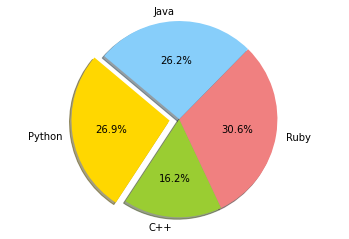

In [133]:
import matplotlib.pyplot as plt

# Data to plot
labels = 'Python', 'C++', 'Ruby', 'Java'
sizes = [215, 130, 245, 210]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
explode = (0.1, 0, 0, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

In [151]:
data = load_json(file_name)

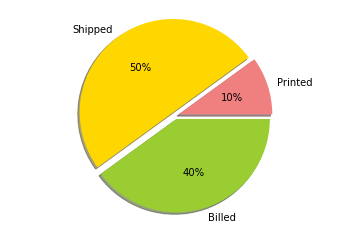

In [159]:
labels =  'Printed', 'Shipped', 'Billed'
sizes = [printed, shipped, billed]
colors = ['lightcoral', 'gold', 'yellowgreen']
explode = (0.04, 0.04, 0.04)

#plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
       autopct='%1.0f%%', shadow=True, startangle=0)

plt.axis('equal')
plt.show()

In [153]:
orders = [i for i in data]

In [154]:
def calc(lst, data, order, status):
    if data[order]["status"] == status:
        lst.append(order)
    return len(lst)

printed_lst = []
shipped_lst = []
billed_lst = []

for order in orders:
    printed = calc(printed_lst, data, order, "Just Received")
    shipped = calc(shipped_lst, data, order, "Shipped")
    billed = calc(billed_lst, data, order, "Billed")

'Hello'

In [62]:
# from pyxll import xl_macro, xl_app, xlcAlert

# xl = xl_app()

# @xl_macro
# def lol():
#     xl = xl_app()
#     xl.Range("A2").Value = "this"

In [58]:
xl.Range("A2").Value = "this"

In [ ]:
# import cv2

# cam = cv2.VideoCapture(0)

# cv2.namedWindow("test")

# img_counter = 0

# while True:
#     ret, frame = cam.read()
#     if not ret:
#         print("failed to grab frame")
#         break
#     cv2.imshow("test", frame)

#     k = cv2.waitKey(1)
#     if k%256 == 27:
#         # ESC pressed
#         print("Escape hit, closing...")
#         break
#     elif k%256 == 32:
#         # SPACE pressed
#         img_name = "opencv_frame_{}.png".format(img_counter)
#         cv2.imwrite(img_name, frame)
#         print("{} written!".format(img_name))
#         img_counter += 1

# cam.release()

# cv2.destroyAllWindows()